# Modeling COVID-19 Spread and Healthcare Capacity # 

Goal is to predict how many COVID-19 patients they will have to provide in-patient medical care for in the next 3 weeks. This will be achieved by modelling the infection rate. Regions that will not have enough resources to cope with their COVID-19 patients in any given week will be matched to a region that will have a surplus of medical resources that week, so that the burden can be shared and more patients can receive life-saving treatment.

In [44]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
from operator import itemgetter
import operator

In [45]:
os.listdir("./")

['.gitmodules', 'COVID-19', '.ipynb_checkpoints', 'modeling_covics.ipynb']

In [46]:
# Load datasets

covid_confirmed = pd.read_csv('./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
covid_deaths = pd.read_csv('./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
covid_recovered = pd.read_csv('./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [47]:
# Load the start of these datasets
#covid_confirmed.head()
#covid_deaths.head()
#covid_recovered.head()

In [48]:
# Extract all column names
cols_keys = covid_confirmed.keys()
# Make sure all datasets have the same columns
# Test this code with covid_confirmed = covid_confirmed.drop(['Lat'], axis=1)
lists = [covid_confirmed.keys(), covid_deaths.keys(), covid_recovered.keys()]
it = iter(lists)
the_len = len(cols_keys)
if not all(len(l) == the_len for l in it):
    raise ValueError('not all lists have same length!')

print(f'Total number of days in database: {len(cols_keys)}')

Total number of days in database: 70


In [49]:
# Collect the counts for each date
confirmed = covid_confirmed.loc[:, cols_keys[4]:cols_keys[-1]]
deaths = covid_deaths.loc[:, cols_keys[4]:cols_keys[-1]]
recovered = covid_recovered.loc[:, cols_keys[4]:cols_keys[-1]]
dates = confirmed.keys()

In [50]:
# Calculate totals, rates, and cumulative counts in the world
total_confirmed_global = []
total_deaths_global = []
total_recovered_global = []
mortality_rate_global = []
for d in dates:
    tmp_conf = confirmed[d].sum()
    tmp_deat = deaths[d].sum()
    tmp_reco = recovered[d].sum()
    total_confirmed_global.append(tmp_conf)
    total_deaths_global.append(tmp_deat)
    total_recovered_global.append(tmp_reco)
    mortality_rate_global.append(tmp_deat/tmp_conf)


In [51]:
# convert to numpy arrays
days = np.array([i for i in range(len(dates))]).reshape(-1,1)
total_confirmed_global = np.array(total_confirmed_global).reshape(-1,1)
total_deaths_global = np.array(total_deaths_global).reshape(-1,1)
total_recovered_global = np.array(total_recovered_global).reshape(-1,1)

In [52]:
# Exponential growth
def func(x, a, b):
    return a * np.exp(b * x) 
# Fit - but not working
#days2 = np.array([i for i in range(len(dates))]).reshape(1,-1)
#popt, pcov = curve_fit(func, days.ravel(),  total_confirmed.ravel())
#plt.plot(days, total_confirmed, 'b-', days, func(days, *popt), 'g--')
popt = [total_confirmed_global[0],0.1075]

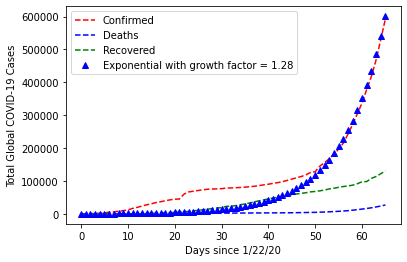

In [53]:
fig, ax = plt.subplots()
ax.plot(days, total_confirmed_global, 'r--', label='Confirmed')
ax.plot(days, total_deaths_global   , 'b--' , label='Deaths')
ax.plot(days, total_recovered_global, 'g--' , label='Recovered')
ax.plot(days, func(days, *popt), 'b^' , label='Exponential with growth factor = %.2f' % 10**popt[1])
plt.legend()
plt.xlabel('Days since %s' % dates[0])
plt.ylabel('Total Global COVID-19 Cases')
plt.show()

In [54]:
# Future forcasting for the next 3 weeks
# dates: actual dates
days_in_future = 21
future_forecast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1,1) # days count including future forecasting
adjusted_dates = future_forecast[:-days_in_future] # days count up to now


In [55]:
# Convert all integers into datetime 
import datetime
start = '1/22/2020'
start_date = datetime.datetime.strptime(start,'%m/%d/%Y')
future_forecast_dates = []
for i in range(len(future_forecast)):
    future_forecast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [56]:
# Latest data
latest_confirmed = covid_confirmed[dates[-1]]
latest_deaths = covid_deaths[dates[-1]]
latest_recovered = covid_recovered[dates[-1]]

In [57]:
# List of unique countries
unique_countries = list(covid_recovered['Country/Region'].unique())

In [58]:
# Total number of cases by each country
total_confirmed_by_country = []
total_deaths_by_country = []
total_recovered_by_country = []
mortality_rate_by_country = []
no_cases = []

for i in unique_countries:
    cases_confirmed = latest_confirmed[covid_confirmed['Country/Region']==i].sum()
    cases_deaths = latest_deaths[covid_confirmed['Country/Region']==i].sum()
    cases_recovered = latest_recovered[covid_confirmed['Country/Region']==i].sum()
    #print(i, len(latest_confirmed[covid_confirmed['Country/Region']==i]))
    if cases_confirmed > 0:
        total_confirmed_by_country.append(cases_confirmed)
    else:
        no_cases.append(i)
    if cases_deaths > 0:
        total_deaths_by_country.append(cases_deaths)
    if cases_recovered > 0:
        total_recovered_by_country.append(cases_recovered)

for i in no_cases:
    unique_countries.remove(i)
# Sort based on the number of cases
unique_countries = [k for k,v in sorted(zip(unique_countries, total_confirmed_by_country), key=operator.itemgetter(1), reverse=True) ]
for i in range(len(unique_countries)):
    total_confirmed_by_country[i] = latest_confirmed[covid_confirmed['Country/Region']==unique_countries[i]].sum()

In [59]:
# Print number of cases per country/area
print('Confirmed cases by Countries/Regions')
for i in range(len(unique_countries[:10])):
    print(f'{unique_countries[i]}: {total_confirmed_by_country[i]} cases' )

Confirmed cases by Countries/Regions
US: 101657 cases
Italy: 86498 cases
China: 81897 cases
Spain: 65719 cases
Germany: 50871 cases
France: 33402 cases
Iran: 32332 cases
United Kingdom: 14745 cases
Switzerland: 12928 cases
Korea, South: 9332 cases


In [64]:
# List of unique province/state
unique_states = list(covid_recovered['Province/State'].unique())

In [65]:
# Total number of cases by each province/state
total_confirmed_by_state = []
no_cases = []
for i in unique_states:
    cases_confirmed = latest_confirmed[covid_confirmed['Province/State']==i].sum()
    if cases_confirmed > 0:
        total_confirmed_by_state.append(cases_confirmed)
    else:
        no_cases.append(i)

for i in no_cases:
    unique_states.remove(i)
    
# Print number of cases per country/area
print('Confirmed cases by Province/State')
for i in range(len(unique_states[:10])):
    print(f'{unique_states[i]}: {total_confirmed_by_state[i]} cases' )

Confirmed cases by Province/State
Australian Capital Territory: 62 cases
New South Wales: 1405 cases
Northern Territory: 12 cases
Queensland: 555 cases
South Australia: 257 cases
Tasmania: 47 cases
Victoria: 574 cases
Western Australia: 231 cases
Anhui: 990 cases
Beijing: 569 cases


In [67]:
# handle missing values
nan_indices = []

for i in range(len(unique_states)):
    if type(unique_states[i]) == float:
        nan_indices.append(i)

unique_states = list(unique_states)
total_confirmed_by_state = list(total_confirmed_by_state)

for i in nan_indices:
    unique_states.pop(i)
    total_confirmed_by_state.pop(i)

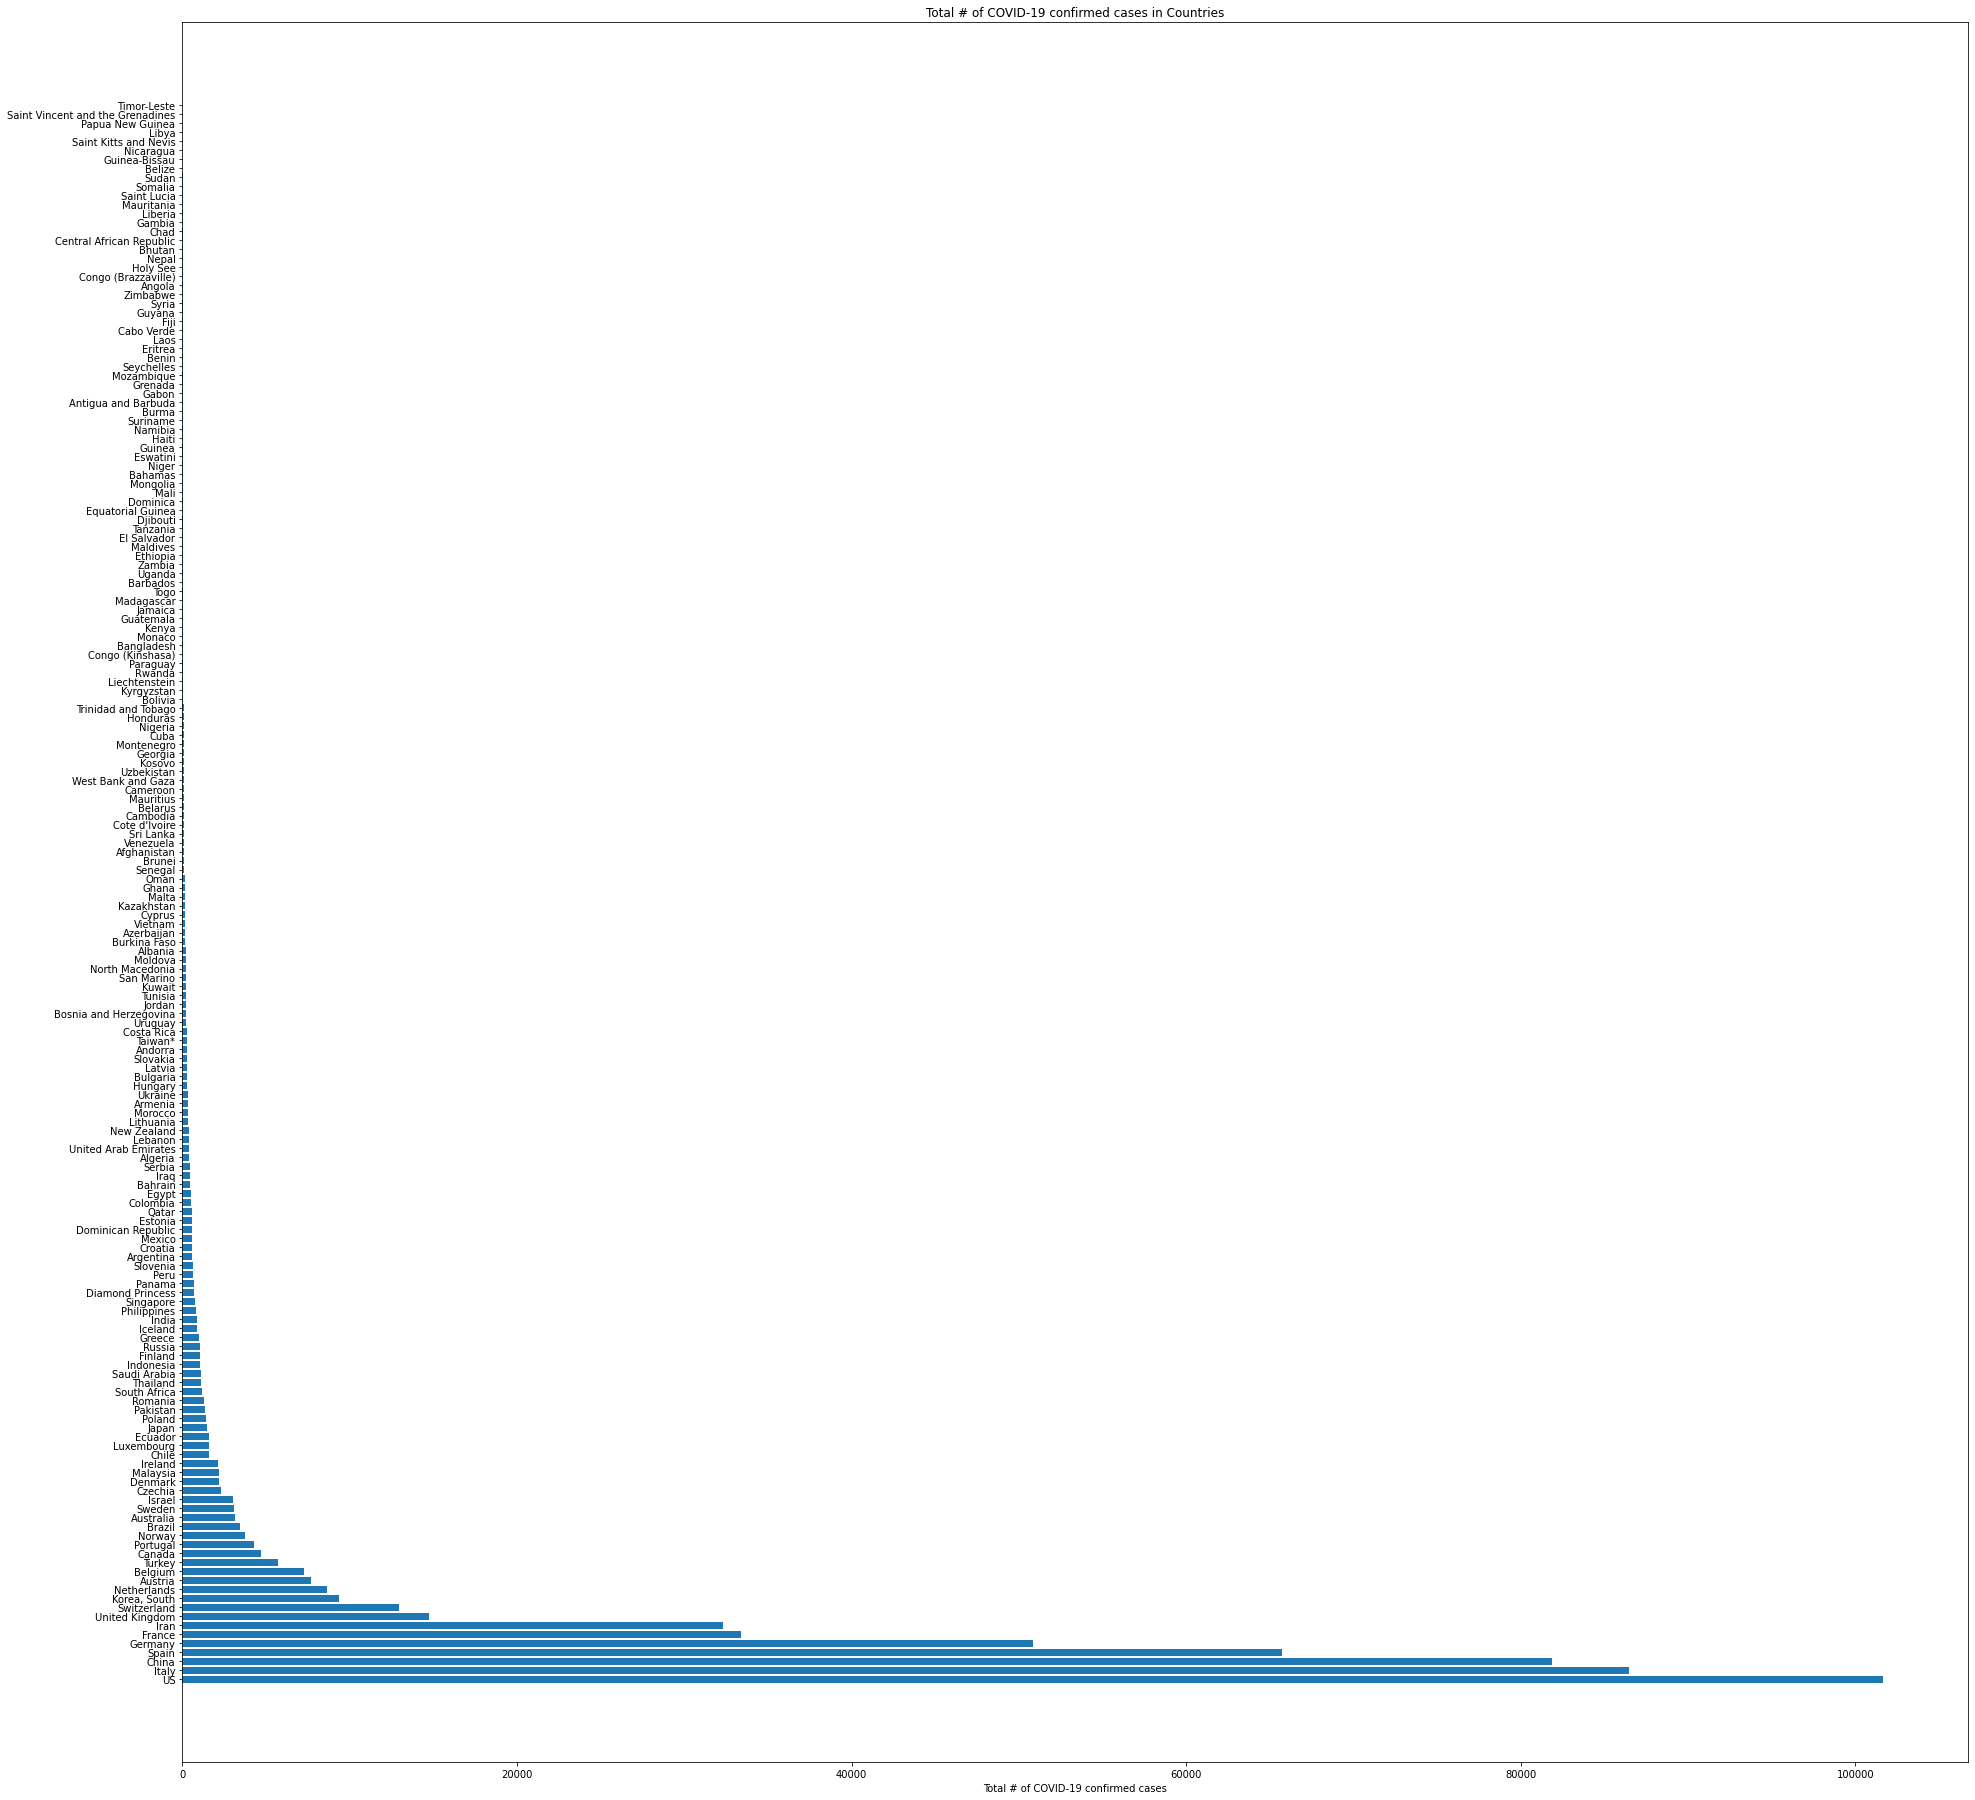

In [76]:
# Some visualization now

plt.figure(figsize=(32,32))
plt.barh(unique_countries, total_confirmed_by_country)
plt.title("Total # of COVID-19 confirmed cases in Countries")
plt.xlabel("Total # of COVID-19 confirmed cases")
plt.show()

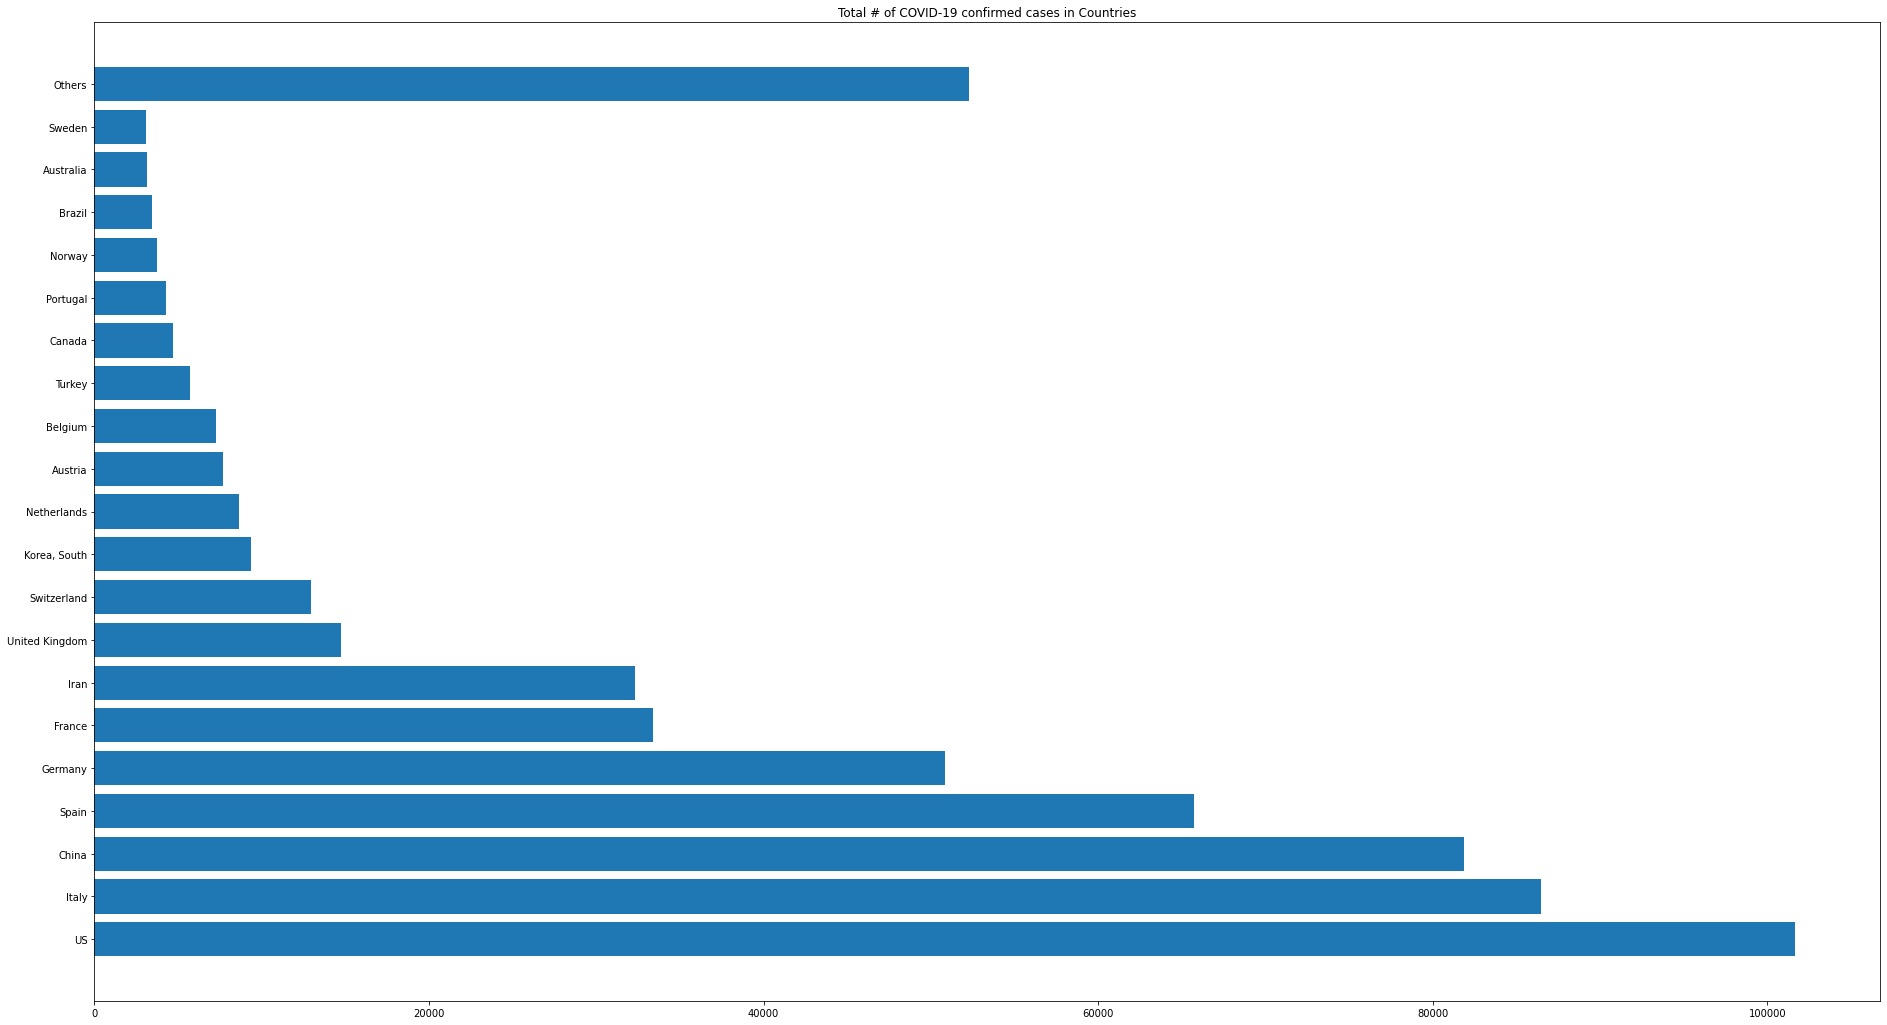

In [82]:
# make it easier to visualize, pick the 10 top cases + other cases
visual_unique_countries = []
visual_confirmed_cases = []
others = np.sum(total_confirmed_by_country[20:])
for i in range(len(total_confirmed_by_country[:20])):
    visual_unique_countries.append(unique_countries[i])
    visual_confirmed_cases.append(total_confirmed_by_country[i])
visual_unique_countries.append('Others')
visual_confirmed_cases.append(others)

plt.figure(figsize=(32,18))
plt.barh(visual_unique_countries, visual_confirmed_cases)
plt.title("Total # of COVID-19 confirmed cases in Countries")
plt.show()

In [91]:
# build simple ML model

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

kernel = ['poly', 'sigmoid', 'rbf']
c = [0.01, 0.1, 1, 10]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
svm_grid = {'kernel': kernel, 'C': c, 'gamma': gamma, 'epsilon': epsilon, 'shrinking': shrinking}

# Prepare data
all_features = total_confirmed_by_country[:-1]
Targeted_feature = total_confirmed_by_country[-1]
print(len(all_features))
#X_train,X_test,y_train,y_test = train_test_split(all_features,Targeted_feature,test_size=0.3,random_state=42)
#X_train.shape,X_test.shape,y_train.shape,y_test.shape


svm = SVR()
svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
#svm_search.fit(X_train_confirmed,y_train_confirmed)

175
